<div style="border:1px solid black; padding:20px 20px;text-align: justify;text-justify: inter-word">
   <strong> Basics of Mobile Robotics: Project Report <br/> Autumn 2021 <br/><br/> Group members: </strong><br/><br/> Henry Papadatos <br/> Juliette Pelissier <br/> Eliott Sizey<br/> Aitana Waelbroeck-Boix
    
    
</div>

# Introduction

### Environment

### State Machine


Our program starts by initialising the environment by analysing the first frame sent by the camera through the vision module. It determines the starting position of the Thymio, the corners of the obstacles and the center of the goals. The optimal path is then defined from those information in the path planning module. <br>
The program then enters into the main loop which follows 4 steps:
- Vision: Determines the pose (position + angle) of the Thymio using the images sent by the camera
- Kalman filter: 
- Local avoidance:
- Motion control: 

PUT STATE MACHINE GRAPH HERE

# Vision

### Principle

The goal of the vision part of the project is to map the environment in which the robot will move (obstacles and goals) and to keep track of its pose. Each element of the environment has a different color which allows color differentiation and localisation. From a frame captured by the camera, the most efficient way of doing color detection is to transform this frame from the BGR domain to the HSV domain and apply a range color filter that turns pixels in the range to white and the other pixels to black. Once this is done, the shapes of the detected objects are also used as described in the following subsections.
### HSV 

The HSV domain can be represented as a cone (figure 1 plotted below) and comprises three parameters that define a color: the hue, saturation and value. The hue is coded in the range [0,360] degrees accordingly to the corresponding angle in the color circle. The saturation corresponds to the intensity of the color and is comprised between 0% and 100%. The value is the "brilliance" of the color, the lower it is, the darker the color is. It is also defined between 0% and 100%. In the opencv library, the three parameters are coded in the following ranges:
- Hue: [0, 180]
- Saturation: [0, 255]
- Value: [0, 255]

The main advantage of using HSV color coding is that it is much easier to calibrate the range of the color filters as the saturation and value parameters make it much less dependent to the change of light on the map (lighting can be much less consistent than if using BGR color coding). In our project, we used three colors: blue for the obstacles, green for the goals and red for the Thymio which are coded in the following ranges ([H, S, V]):
- Blue: [0-20,50-255,0-255]
- Green: [50-70,50-255,50-255]
- Red: [115-130,50-255,50-255]

<img src='images report\HSV cone.png' alt="Modules" style="width: 400px;"/>

### Obstacles 

The creation and application of the range color filter is done using the function color_detection() for each object of the environment. The ranges of the HSV parameters for the In the top right image plotted below, we illustrate the result of using this function for the obstacles but it works similarly for the Thymio and the goals.

<IPython.core.display.Javascript object>


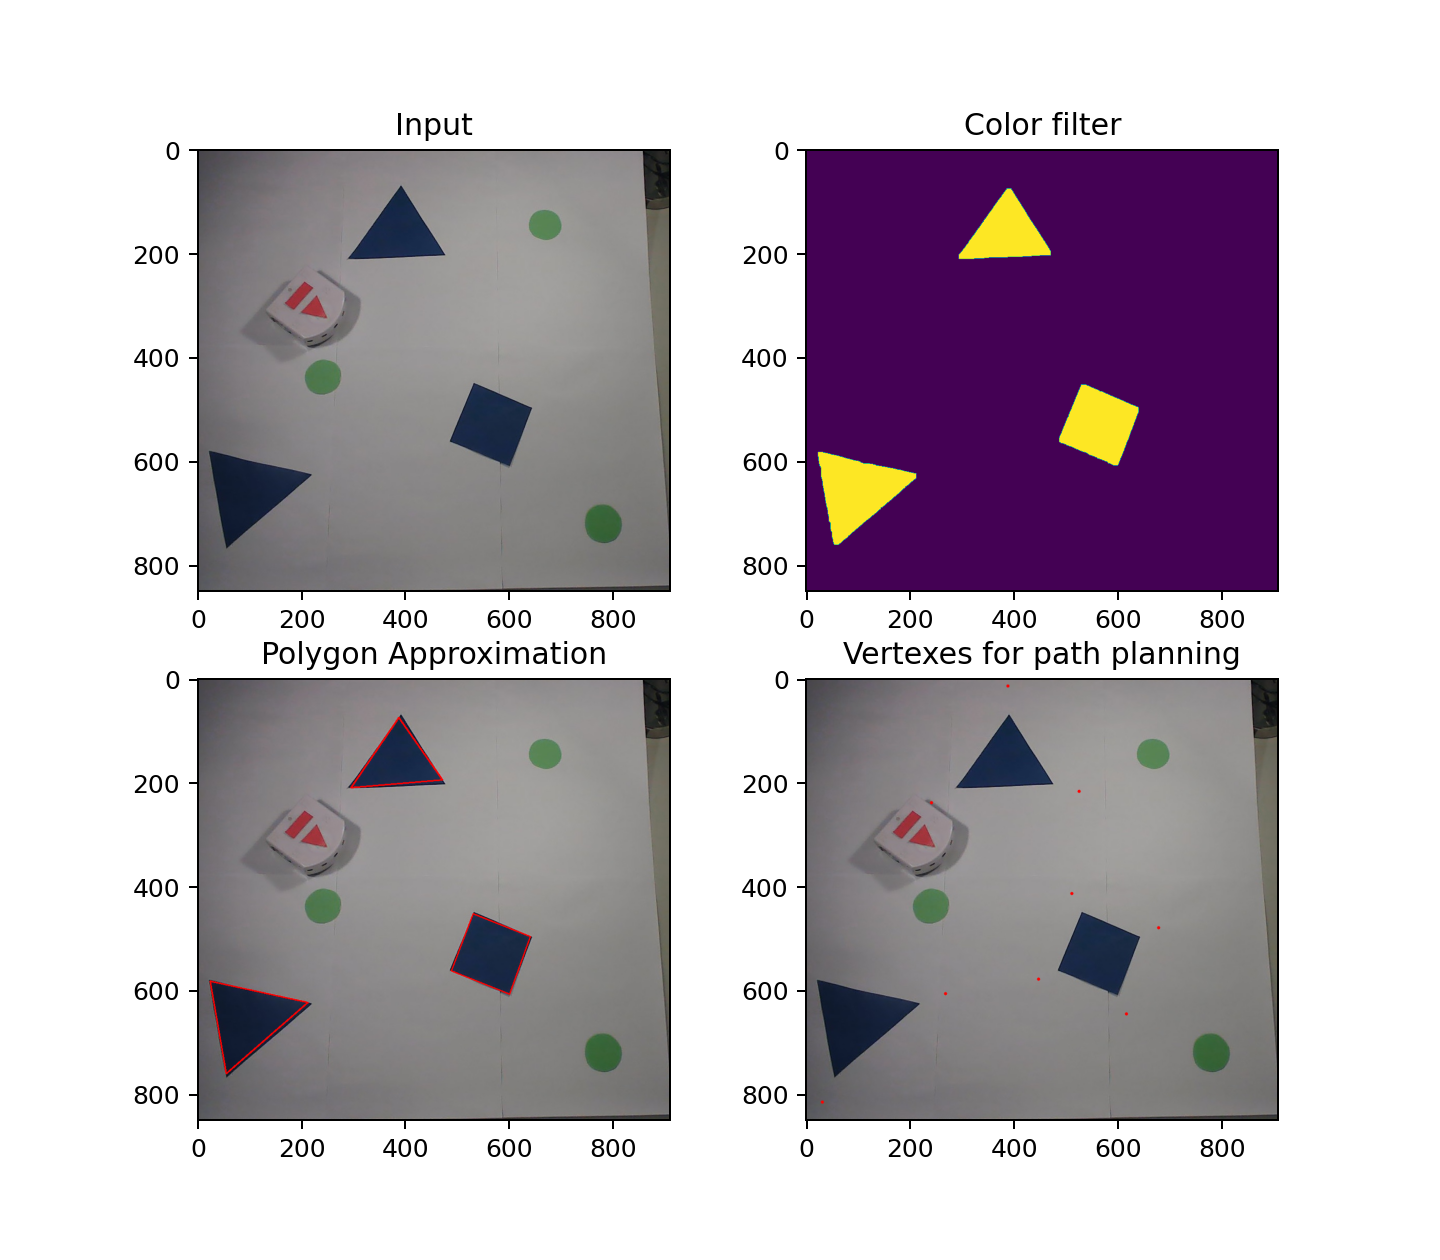

In [16]:
import cv2
import math
import numpy as np
%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

SAFETY_FACTOR = 20 # margin so that the robot doesn't hit obstacles 
POLY_FACTOR_OBST = 0.05 # factor that determines how accurately the approxPolyDP function approximates
LEN_IN_MM = 113 # lenght of one side of the cube in mm

BLUE_LOW_H = 0
BLUE_HIGH_H = 20
BLUE_LOW_S = 50
BLUE_HIGH_S = 255
BLUE_LOW_V = 0
BLUE_HIGH_V = 255

def obstacles(img):
    """
    Extract obstacles from image "img", approximate them as polygons, find their corners and expand them
    
    param pic : image captured by the camera
    
    return new_corners : coordinates of the expanded obstacles corners
    return Pix_to_mm : pixel to millimeter conversion factor
    return img_goals : original image with black pixels except for the obstacles
    """
    low_blue = np.array([BLUE_LOW_H, BLUE_LOW_S, BLUE_LOW_V])
    high_blue = np.array([BLUE_HIGH_H, BLUE_HIGH_S, BLUE_HIGH_V])
    corners=[]
    new_corners=[]
    centroids=[]
    img_contours=img.copy()
    img_final = img.copy()
    
    img_obst, mask_obst = color_detect(img, low_blue, high_blue)
    contours, hierarchy = cv2.findContours(mask_obst, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find largest area for noise condition
    areas = [cv2.contourArea(c) for c in contours]
    
    if not areas:
        cv2.imshow('mask', mask_obst)
        cv2.waitKey(0)
        raise ValueError("Can not read frame")
        
    max_cont = max(areas)
    
    # For each contour found, approximate it as a polygon and extract its corners
    for cont in contours:
        epsilon = POLY_FACTOR_OBST * cv2.arcLength(cont, True)
        approx = cv2.approxPolyDP(cont, epsilon, True)
        
        if(len(approx)>2 and cv2.contourArea(approx) >= max_cont/3): # Condition to get rid of detected noise 
            cv2.drawContours(img_contours, [approx], -1, (0, 0, 255), 2)
            corners.append(approx)
            if(len(approx) == 4): # Use rectangle obstacle to find the pixel to millimeter conversion factor
                Pix_to_mm = pix_to_mm(approx)
    
    # From extracted corners, define middle point of each object and create vertex (by 'expanding' corners)
    
    for i in range(0, len(corners)):
        centroids.append(centroid(corners[i]))
        new_corners.append(expand(centroids[i], corners[i], Pix_to_mm))   # Determine expanded corners (to take into account thymio width)    
    
        for corn in new_corners[i]:
            cv2.circle(img_final, corn, 3, (0, 0, 255) , -1)

    return new_corners, Pix_to_mm, mask_obst, img_final, img_contours

def color_detect(pic, low, high):
    """
    Extract color from the image "pic" based on the HSV color range [low-high]
    
    param pic : image on which the color detection is conducted
    param low : contains the lower values of the HSV parameters range
    param high : contains the higher values of the HSV parameters range
    
    return color_img : original image with black pixels except for the color detected
    return mask : black and white color filter
    """
    
    sigma = (5,5)
    
    image=cv2.blur(pic, sigma)                 # Blurring to get rid of image noise
    image=cv2.cvtColor(pic, cv2.COLOR_RGB2HSV) 
    mask=cv2.inRange(image, low, high)
    mask=cv2.erode(mask, None, iterations=4)    # Processing to have smoother color filter
    mask=cv2.dilate(mask, None, iterations=4)   

    color_img =cv2.bitwise_and(pic, pic, mask=mask)
    
    return color_img, mask

def expand(centroid, vertexes, px_factor):
    """
    Computes the expanded vertexes of a polygon based on the coordinates of its corners and centroid
    
    param centroid : coordinates of centroid of obstacle 
    param vertexes : corners coordinates of obstacle
    param px_factor : pixel to millimeter conversion factor
    
    return new_corners : coordinates of expanded corners
    """
    
    
    half_thymio = SAFETY_FACTOR*(1/px_factor) # Thymio's half width - converted from mm to pixels
    if(len(vertexes) == 3): 
        expansion_dist = half_thymio/np.cos(np.pi/3) # For triangular obstacles
        
    else:
        expansion_dist = math.sqrt(2*half_thymio**2) # For rectangular obstacles
        
        
    new_corners = []
    
    for vertex in vertexes:
        dist = [(vertex[0][0] - centroid[0]), (vertex[0][1] - centroid[1])] # Distance between centroid and corner
        angle = np.arctan2(dist[1], dist[0])                                # Angle between centroid and corner
        new_coord = [vertex[0][0] + np.cos(angle)*expansion_dist, vertex[0][1] + np.sin(angle)*expansion_dist]
        new_corners.append(new_coord)
    
    new_corners = np.int0(new_corners)
    return new_corners

def centroid(vertexes):
    """
    Computes the coordinates of the centroid of a polygon given its corners coordinates
    
    param vertexes : corners coordinates of polygon
    
    return (x,y) : tuple of coordinates of the centroid of the polygon
    """
    
    x_list = [vertex [0][0] for vertex in vertexes]
    y_list = [vertex [0][1] for vertex in vertexes]
    length = len(vertexes)
    x = np.int0(sum(x_list) / length)
    y = np.int0(sum(y_list) / length)
    
    return(x, y)

def pix_to_mm(rectangle):
    """
    Extract longest side of rectangle and computes pixel to millimeter conversion factor from it
    
    param rectangle : coordinates of the corners of the rectangular obstacle
    
    return px_to_mm : pixel to millimeter conversion factor
    """
    len_in_px = 0
    
    for corn1 in rectangle:
        for corn2 in rectangle:
            if(np.any(corn1 != corn2)):
                dist = math.dist(corn1[0], corn2[0])
                if(dist > len_in_px):
                    len_in_px = dist

    px_to_mm = LEN_IN_MM/len_in_px
    
    return px_to_mm

img = cv2.imread('Images report/image_vision.jpg', cv2.IMREAD_COLOR)
vertexes, px_factor, mask, img_obst, img_contours = obstacles(img)
plt.figure(figsize=(8, 7))
plt.subplot(221),plt.imshow(img[:,:,::-1]),plt.title('Input')
plt.subplot(222),plt.imshow(mask),plt.title('Color filter')
plt.subplot(223),plt.imshow(img_contours[:,:,::-1]),plt.title('Polygon Approximation')
plt.subplot(224),plt.imshow(img_obst[:,:,::-1]),plt.title('Vertexes for path planning')
plt.show()

As can be seen from this figure, the obstacle() function does not only extract the obstacles from the image but it also find the corners of the obstacles and expand them in order to take into account the real size of the robot. This is done following those steps: 
- finding the contours of the color filter image
- approximating those contours as polygons (see image "Polygon approximation") and extracting their corners
- expanding the corners using the centroids() and expand() functions (see image "Vertexes for path planning" in which red dots represent the vertexes)

Another important feature of the obstacle() function is to calculate the pixel to millimeter conversion factor by dividing the measured length (113mm) of the longest side of the rectangle obstacle by its length in pixels. <br><br>

The distance by which the corners are expanded depends on the shape of the obstacle as we want to make sure that the robot doesn't hit the obstacle when going from one of its corners to an other. By doing simple trigonometry, we obtain that the expansion distance should be (as can bee seen on the figure below):
- Triangle : $dist_{expansion}$ = $\frac{width_{thymio}}{cos(60)}$
- Rectangle : $dist_{expansion}$ = $\sqrt{2 * \frac{width_{thymio}}{2}^2}$

<img src='images report\Expansion vision.jpg' alt="Modules" style="width: 400px;"/>

### Goals 

The center of the goals are defined in a very similar way. Once the contours are extracted from the color filter, the smallest enclosing circle is fitted to each goal and its center is returned. In the plot below, the centers of the goals are drawn as red dots.

<IPython.core.display.Javascript object>


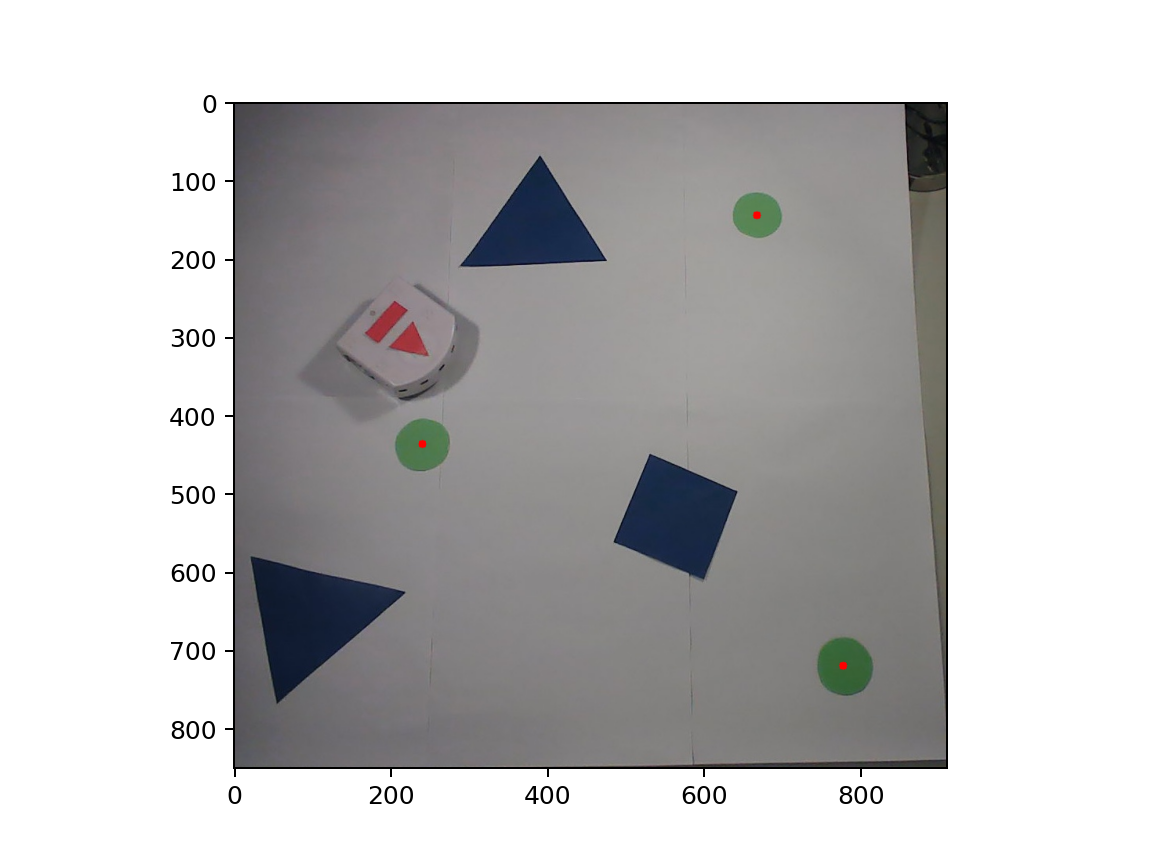

In [4]:
GREEN_LOW_H = 50
GREEN_HIGH_H = 70
GREEN_LOW_S = 50
GREEN_HIGH_S = 255
GREEN_LOW_V = 50
GREEN_HIGH_V = 255

def goals(pic):
    """
    Extract goals from image "pic" and find their centers
    
    param pic : image captured by the camera
    
    return goals_loc : coordinates of the centers of the goals
    return img_goals : original image with black pixels except for the goals
    """
    
    low_green = np.array([GREEN_LOW_H, GREEN_LOW_S, GREEN_LOW_V])
    high_green = np.array([GREEN_HIGH_H, GREEN_HIGH_S, GREEN_HIGH_V])

    goals_loc = []
    img_goals = pic.copy()
    
    # Extract goals from original image through color detection
    colored_mask, mask_goals = color_detect(pic, low_green, high_green)

    contours=cv2.findContours(mask_goals, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
    
    # For each contour found, fit the minimum enclosing circle and extract center
    for cont in contours: 
        
        ((x, y), rayon)=cv2.minEnclosingCircle(cont)
        goals_loc.append(np.array([int(x),int(y)]))
        
    #draw centers of goals
    for cent in goals_loc:
        cv2.circle(img_goals, cent, 5, (0, 0, 255) , -1)
    
    return goals_loc, img_goals

goals_centers, img_goals = goals(img)
plt.figure()
plt.imshow(img_goals[:,:,::-1])

### Thymio 

The red rectangle placed on top of the Thymio is at the center of the wheels axis and is detected in the same way as the obstacles to determine the position of the robot. Thus, we won't describe this implementation. However, to have the full pose of the Thymio, we also need its orientation. This is made possible by the red triangle which allows to detect the position of a second point on the Thymio, from which the orientation can be calculated. Once the centers of the rectangle and triangle are computed, the angle is calculated using those two lines of code:

The arctan2() function returns an angle in the range $[-\pi, \pi]$ which is then converted to the $[0, \pi]$ range by doing modulo 2$\pi$. The angle obtained represents the clockwise orientation of the robot with respect to the horizontal axis of the camera and with origin at the center of the red rectangle (see representation below).
<img src='images report\Angle robot.jpg' alt="Modules" style="width: 400px;"/>

# Global Navigation

Once the position of the robot, of the goals and of the obstacles are know, we need to find the shortest path that visits all the goals and come back to the starting position while avoiding obstacles.

The path planning is devided in two subfunctions:
1. Visibility graph algorithm: find the shortest path between all pairs of goal/goal and goal/start positions and store their lengths.
2. Travelling salesman problem: run a genetic algorithm with the distance that separates the points equal to the lengths found in the previous step.

## Visibility graph

In this function, I used the library pyvisgraph (https://github.com/TaipanRex/pyvisgraph).

The first step is to generate the visibility graph. We need to know the "neighbors" of each point and the distance between each point and its neighbors. 

To know if point a and b are neighbors, we need to check if the segment [a,b] intersects with any of the segments reprensenting the sides of the obstacles. 
If it is not the case, we can connect a and b in a the visibility graph and store the distance that separates them.

This is done with the function g.build(polys) at line 69 in the code below.

<img src='images report\vis1.png' alt="Modules" style="width: 400px;"/>

*Example if a visibility graph (source: https://fribbels.github.io/shortestpath/writeup.html)*


I then apply the Djikstra algorithm to find the sortest path between all pairs of goal/goal and goal/start positions.

Therefore, if n = number of goal + 1 (+1 to add the start position) and k is the number of nodes in the visibility graph. The complexity of the Djikstra algotithm is $O(k^2)$ and we need to solve the Djikstra algorithm $n!$ times. 
This is very not optimal if n gets big. The total complexity is $O(n!*k^2)$. 
What I could have done to reduce that complexity is to modify the Djikstra algotithm such that it finds the shortest path from one point to all other points in one execution. I would then need to solve that modified Djikstra only n times and the total complexity would have been $O(n*k^2)$.

In our use case, $k=15$ and $n=4$. Therefore $O(n*k^2) = 900$ and $O(n!*k^2) = 5400$. 

The difference is not huge, and the later option only needs around 0.015 seconds to run on my computer. Therefore, I decided to reuse the function that comes from the pyvisgraph library and I called it $n!$ times. 

100%|██████████| 2/2 [00:00<00:00, 1038.58it/s]

Elapsed time is: 0.018228769302368164


<IPython.core.display.Javascript object>


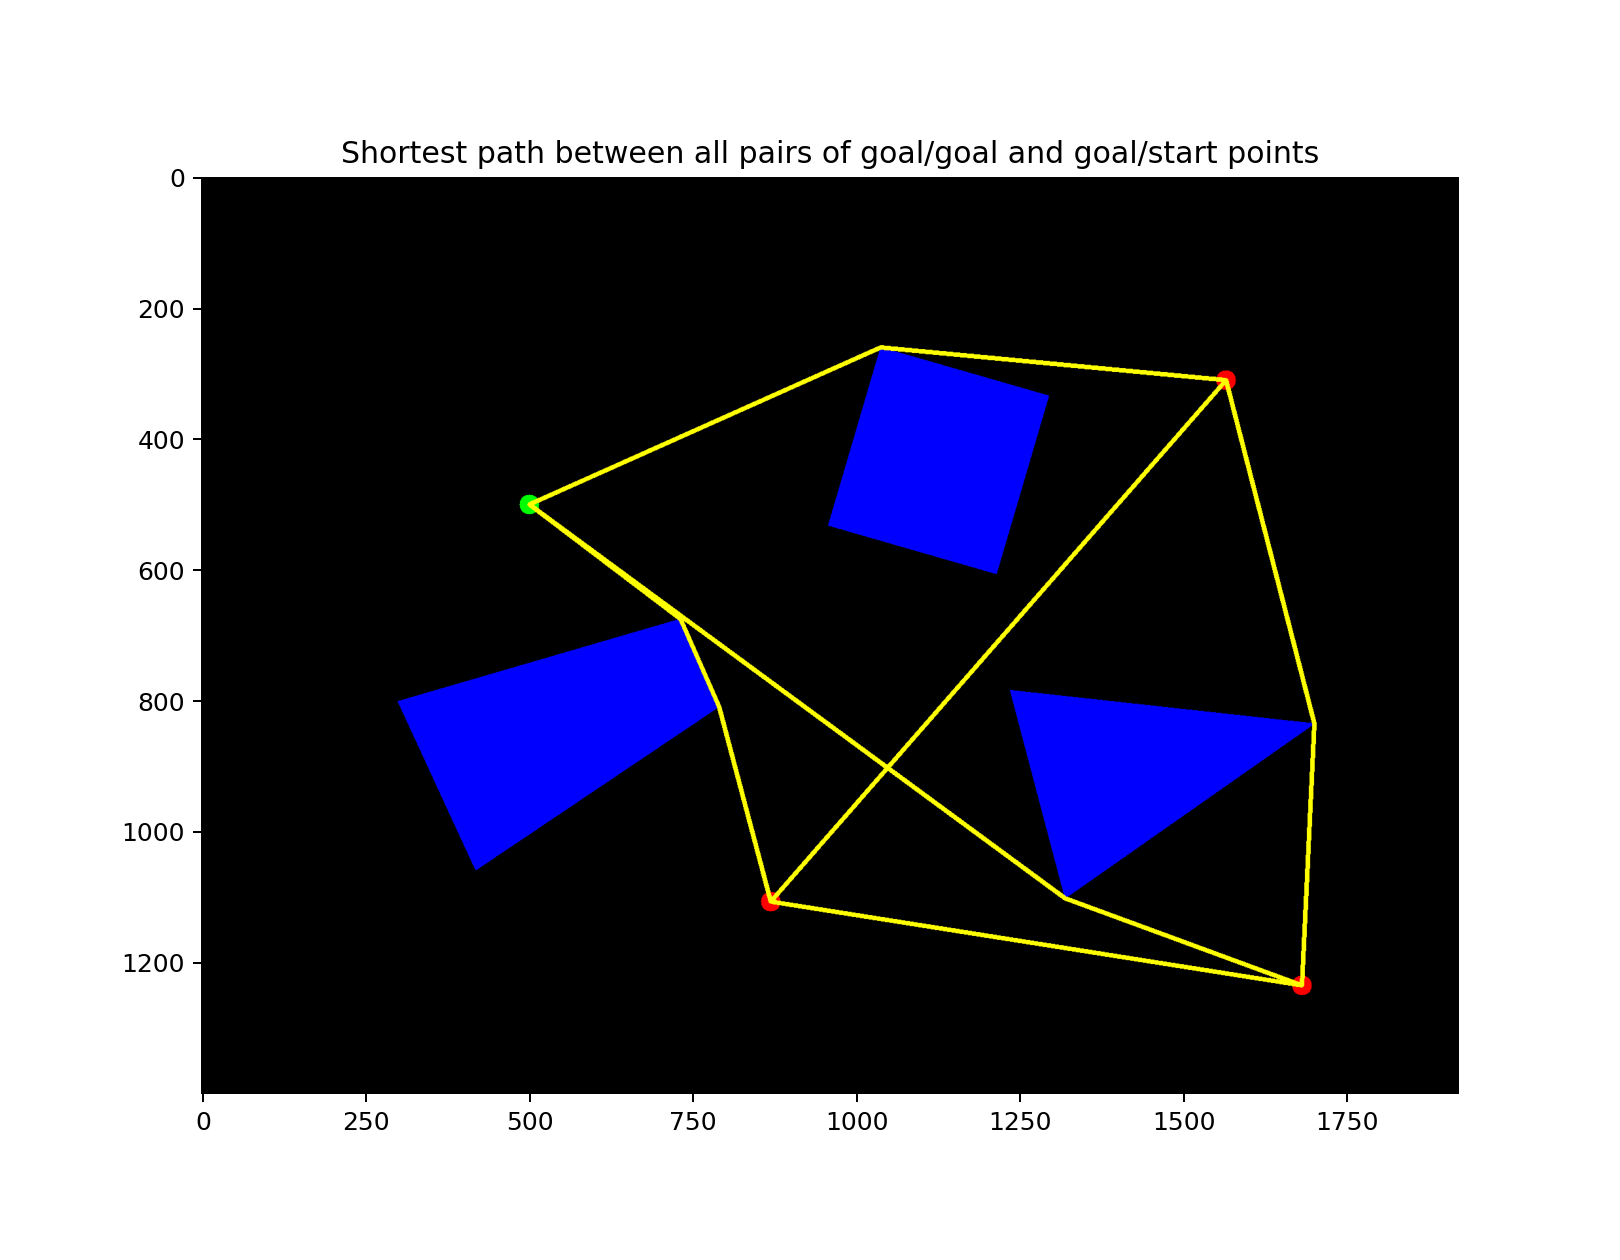

Legend: 
Green point: start point
Red points: goal points
Blue polygons: obstacles
Yellow lines: shortest paths


In [1]:
import pyvisgraph as vg
import numpy as np
import cv2
import math
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose
%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook
import time

def draw(image, start, goal, obstacle):
        
        cv2.circle(image, start,radius=0, color=(0,255,0), thickness=30)

        for current_goal in goal:
            cv2.circle(image, current_goal,radius=0, color=(255,0,0), thickness=30) 

        #draw obstacle
        cv2.fillPoly(image, obstacle, color=(0,0,255))

def path_length(path):
    """
    Computes the length of a path
    
    param path: positions of all the points composing the path
    
    return distance: length of the path
    """
    distance = 0
    for i in range(len(path)-1):
        distance += math.sqrt((path[i].x-path[i+1].x)**2 + (path[i].y-path[i+1].y)**2)
    
    return distance

def visibility_graph(start, goal, obstacle,draw = False, image = None):
    """
    Use visibility graph and Djikstra algorithm to find the shortest distance 
    and its corresponding path between each pair of goals.
    This library is used: https://github.com/TaipanRex/pyvisgraph
    
    param start: position of the robot at the beginning
    param goal: list of position of goals where the robot has to go
    param obstacle: list of position of the corners of the extended obstacles
    param draw: if True, all the shortest path between pair of goals/start will be ploted
    param image: the image on which we draw the path
    
    return dist_list: list of the lengths of all shortest paths
    return path_list: list of intermediate coordinates composing each of shortest path
    """
    
    polys = [] 
    #creates the list of obstacle with the format needed by pyvisgraph library
    for cobstacle in obstacle: 
        cpolys = []
        for cpos in cobstacle:
            cpolys.append(vg.Point(cpos[0],cpos[1])) 
        polys.append(cpolys)
    
    #point is the list of goals in wich we insert the start position
    point = goal.copy()
    point.insert(0, start)
    dist_list=[]
    path_list=[]

    #create the visibility graph
    g = vg.VisGraph()
    g.build(polys)
        
    #for each pair of point (in point list), we compute the shortest path
    for i in range(len(point)):
        for k in range(len(point)-i-1):
            j = k+i+1
            #computes the shortest path between point i and j
            shortest = g.shortest_path(vg.Point(point[i][0], point[i][1]), vg.Point(point[j][0], point[j][1]))
            #add the shortest path into the path_list
            path_list.append([i, j, shortest])
            #add the length of the sortest path in the dist_list
            dist_list.append((i, j, path_length(shortest)))
            
            #if param draw = True, draw all the sortest paths on param image
            if draw:
                h = 0
                for h in range (len(shortest)-1):
                    dstart = np.array([int(shortest[h].x), int(shortest[h].y)])
                    dend = np.array([int(shortest[h+1].x), int(shortest[h+1].y)])
                    image = cv2.line(image,dstart, dend, color=(255,255,0), thickness = 5)
                
    return dist_list, path_list

#Exemple data
start = np.array([500,500])

goal = []
goal.append(np.array([1681,1235]))
goal.append(np.array([ 869, 1107]))
goal.append(np.array([1565, 310]))

obstacle = []
obstacle.append(np.array( [[1235,  784],[1319, 1102],[1700,  835]]))
obstacle.append(np.array( [[ 731,  675],[ 299,  801],[ 418, 1059],[ 790,  809]])) 
obstacle.append(np.array( [[1037,  260],[ 957,  532],[1214,  606],[1294,  334]])) 

#empty black image
image = np.zeros((1400,1920,3), np.uint8)

#draw the elements in the map
draw(image, start, goal, obstacle)

previous_time = time.time()

#compute the shortest distance between all pairs of goal/goal and goal/start positions
dist_list, path_list = visibility_graph(start, goal, obstacle, True, image)

print("Elapsed time is:", time.time()-previous_time)

plt.figure(figsize=(9, 7))
plt.imshow(image)
plt.title('Shortest path between all pairs of goal/goal and goal/start points')
# plt.legend('test')
plt.show()

print('Legend: \nGreen point: start point\nRed points: goal points\nBlue polygons: obstacles\nYellow lines: shortest paths')

## Travelling salesman problem

We now know the "distance" that separates each point that we need to visit. 

Note that the distance that separates each point is not the euclidian distance! It is the length of the shortest path that separates those 2 points. 

We need to find the shortest path that visit all of the points and then go back to the start position.

This problem is called the travelling salesman problem and is very well documented. 

To solve it, I used the library mlrose (https://github.com/gkhayes/mlrose). It uses a genetic algorithm to solve the travelling salesman problem. 

Note that given our low number of points, I could have used the brute force method and still solve the problem in a reasonable amout of time. But I thougth that using a genetic algorithm is more elegant.

<IPython.core.display.Javascript object>


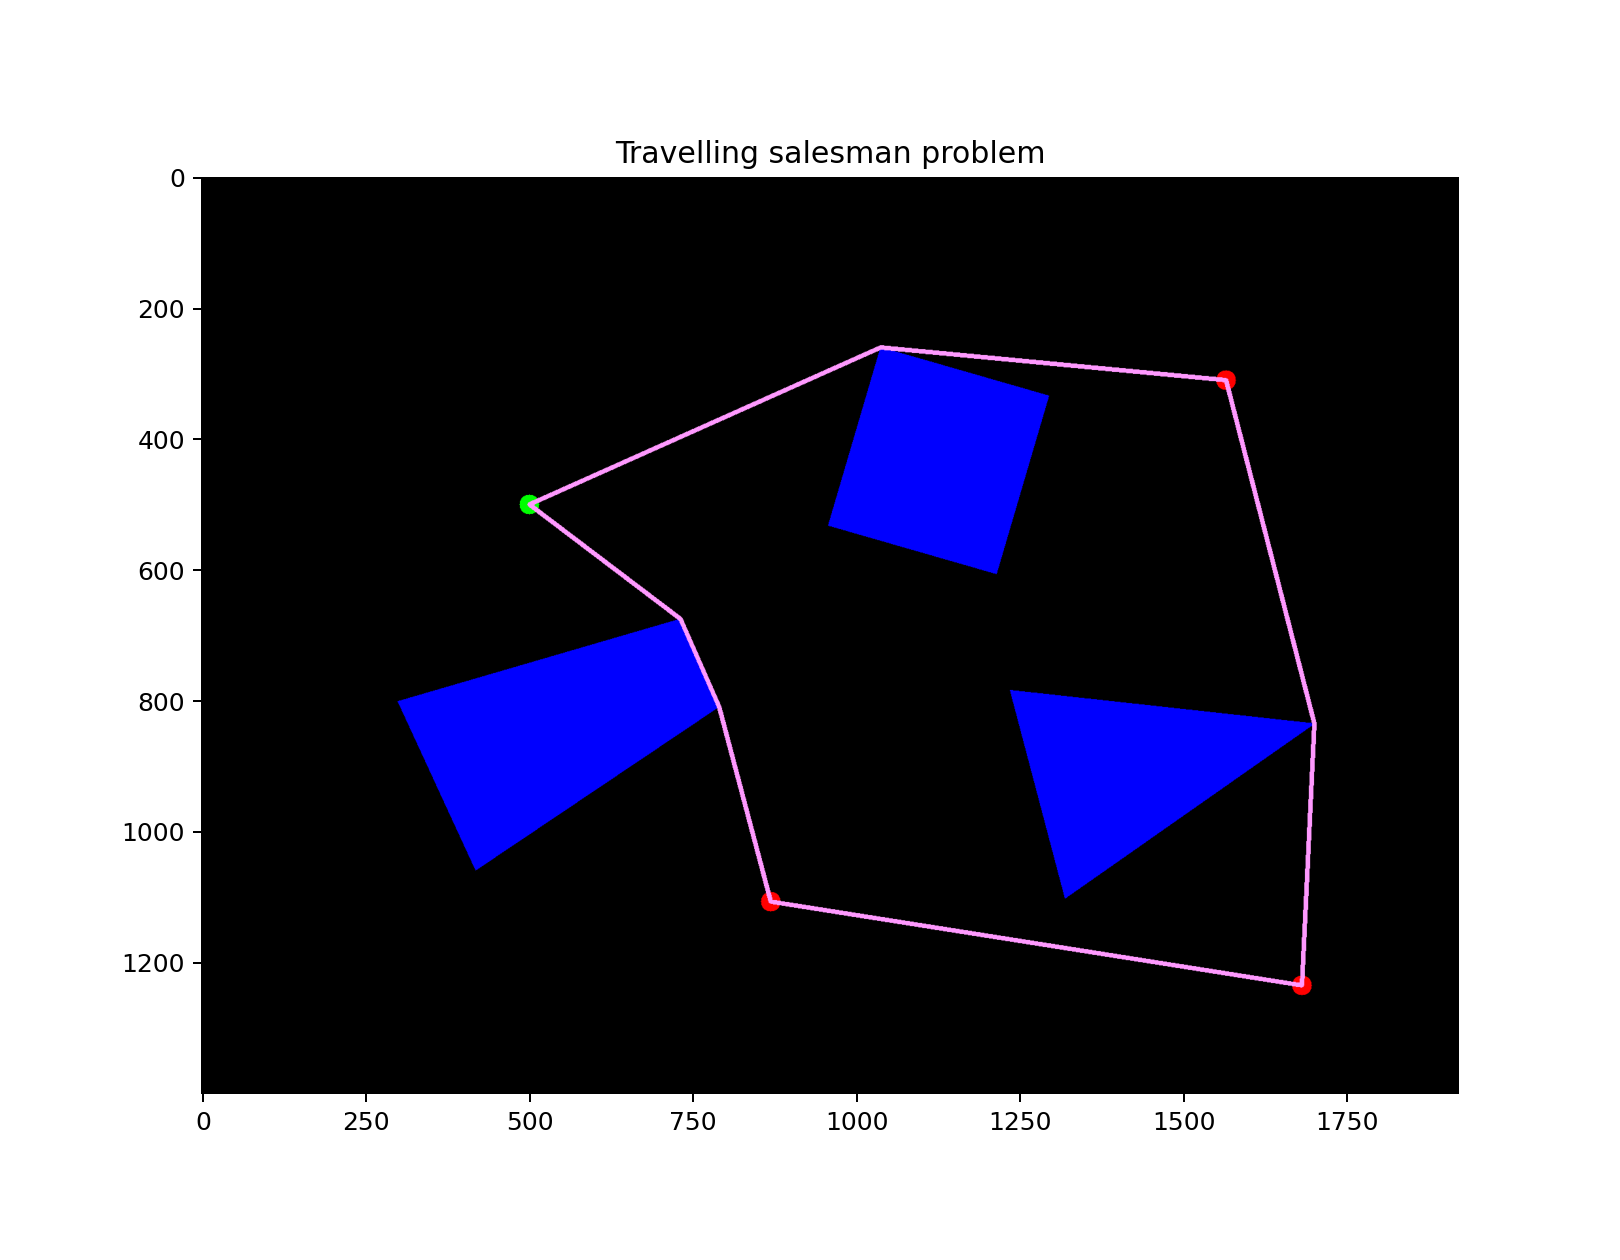

Legend: 
Green point: start point
Red points: goal points
Blue polygons: obstacles
Pink line: shortest path to visit all the goals and go back to starting point while avoiding obstacles


In [2]:
def tsp(dist_list, path_list, length, draw = False, image = None):
    """
    Solve the travelling salesman problem using a genetic algorithm.
    The library used is mlrose: https://github.com/gkhayes/mlrose
    
    param dist_list: list of the lengths of all shortest paths
    param path_list: list of intermediate coordinates composing each of shortest path
    param length: number of points to travel to
    param draw: if True, all the shortest path between pair of goals/start will be ploted
    param image: the image on which we draw the path
    
    return optimal_trajectory: list of points that compose the optimal path (expressed in pixel coordinates)
    """
    
    optimal_trajectory=[]

    # Initialize fitness function object using dist_list (dist_list is the length of the 
    # pairwise shortest path computed in Astar function)
    fitness_dists = mlrose.TravellingSales(distances = dist_list)
    # Define optimization problem object
    problem_fit2 = mlrose.TSPOpt(length, fitness_fn = fitness_dists, maximize = False)
    # Solve using genetic algorithm
    best_state, best_fitness = mlrose.genetic_alg(problem_fit2, mutation_prob = 0.2, max_attempts = 100,
                                                  random_state = 2)
    
    #rearrange best state so that the path starts at the start position
    while best_state[0] != 0:
        best_state = np.roll(best_state,1)
        
        
    #fill the optimal tarjectory list using best_state and path_list
    for i in range(len(best_state)):
        start = best_state[i]
        if i == len(best_state)-1:
            stop = best_state[0]
        else:
            stop = best_state[i+1]
            
        for segment in path_list:
            if (segment[0] == start and segment[1] == stop):
                segment_path = segment[2]
                for j in range(len(segment_path)-1):
                    optimal_trajectory.append(np.array([segment_path[j].x, segment_path[j].y]))
            if (segment[1] == start and segment[0] == stop):
                segment_path = segment[2]
                for k in range(len(segment_path)-1):
                    j = len(segment_path) - 1 - k
                    optimal_trajectory.append(np.array([segment_path[j].x, segment_path[j].y]))
        
    optimal_trajectory.append(np.array([path_list[0][2][0].x,path_list[0][2][0].y]))  
    
    #if param draw = True, draw the sortest path on param image
    if draw:
        for i in range(len(optimal_trajectory)):
            start = optimal_trajectory[i].astype(int)
            if i == len(optimal_trajectory)-1:
                stop = optimal_trajectory[0].astype(int)
            else:
                stop = optimal_trajectory[i+1].astype(int)
                
            image = cv2.line(image,start, stop, color=(255, 153, 255), thickness = 5)
    
   
    return optimal_trajectory

#empty black image
image = np.zeros((1400,1920,3), np.uint8)

#draw the elements in the map
draw(image, start, goal, obstacle)

#compute the Travelling salesman problem algorithm and plot the paths
optimal_path = tsp(dist_list, path_list, len(goal)+1, draw, image)


plt.figure(figsize=(9, 7))
plt.imshow(image)
plt.title('Travelling salesman problem')
plt.show()
print('Legend: \nGreen point: start point\nRed points: goal points\nBlue polygons: obstacles\nPink line: shortest path to visit all the goals and go back to starting point while avoiding obstacles')

# Local Navigation

When following its global path previously calculated, the Thymio is sensing its environment. In case an unpredicted obstacle appears on its way, it detects it and tries to avoid it.
Based on the Artificial Neural Network technique, we added weights as fixed connections between the horizontal proximity sensors and the two motors. This way, we have a reactive control that we tuned empirically.

We made the choice to use the ANN with memory to have a recurrent connection, that allows in most simple cases to avoid bumping into an obstacle and get far enought to be able to get back in the planed path tracks !                                                         
To get access to the synchronized variables from the Thymio, we added two functions in our main, with the `@tdmclient.notebook.sync_var`. This permits us to have updates values from the sensors and synchronize the wheels' speed with respect to it.


Basically, the function is a local avoidance with memory, you can find its code below.

In [ ]:
def obstacle_avoidance(horz_prox, speedl, speedr, verbose = False):
    
    '''
    Computes the speed of the robot depending of the distance to the obstacle,
    based on an Artificial Neural Network with memory.
    
    INPUT
        :param horz_prox 
            1x7 NumPy Array collecting the values from the horizontal 
            proximity sensors
        :param speedl, speedr 
            respective current speeds of left and right motors
             
    OUTPUT
        :return y 
            1x2 NumPy Array [speedl, speedr] of speeds of the wheels [mm/s]
        :return state
            state of the robot 
            1 --> obstacle avoidance
            0 --> goal tracking
    '''
    
    w_l = [20,  20, -20, -20, -20,  0, 0, 1, 0]
    w_r = [-22, -22, -22,  22, 22, 0, 0, 0, 1]

    x = [0,0,0,0,0,0,0,0,0]
    
    y = [speedl,speedr]
   
    # Memory
    x[7] = y[0]/CST_SCALE
    x[8] = y[1]/CST_SCALE
    
    if verbose: print("remanent left speed: ", x[7])
    if verbose: print("remanent right speed: ", x[8])

    for i in range(7):
        # Get and scale inputs
        x[i] = horz_prox[i] / SENS_SCALE

    y = [0,0]   

    for i in range(len(x)):    
        # Compute outputs of neurons and set motor powers
        y[0] = y[0] + x[i] * w_l[i]
        y[1] = y[1] + x[i] * w_r[i]
        
    y[0] = int(y[0]+AVG_SPEED)
    y[1] = int(y[1]+AVG_SPEED)
    
    if verbose: print("left speed: ", x[7])
    if verbose: print("right speed: ", x[8])
        
    state = 1
    
    if y[0]<=SPEED_TRH and y[1]<=SPEED_TRH:
        # Back to goal tracking
        state = 0
        
    return y, state

It manages the `state` of the robot, avoiding us to have a parallel loop to handle obstacle avoidance and keep our main running.

We decided not to take into account the back sensors as the robot won't go backwards and it makes it easier to manipulate it, for a kidnapping as an example.

If the add of the memory allows a smoother avoidance of the unpredicted obstacle, the add of the `AVG_SPEED` to the speed of the motors allows a better avoidance. Indeed, once the sensors don't detect the obstacle anymore, the robot wants to turn back in the tracks of its optimal path, but it hasn't not necessarily overcome the obstacle. 

# KALMAN FILTER

The robot's position can be obtained eitheir by measuring it with the camera, or by predicting the robot's position relying on the odometry. The goal of the Kalman filter to compute a better estimation of the position by taking both of these methods into account. Each of these ways of obtaining the position has its own uncertainties (level of error). The estimation will relie more on the method whose variance of the error is smaller. In our case, it will relie more on the camera measurements, since they are more precise.

However, the prediction of the odometry will be useful when the camera is not able to detect the position of the robot (ex: when the camera is hidden or the camera doesn't suceed and detecting the robot). In this case, the estimation of the position will use the prediction of the odometry to ensure a good positioning of the robot until the camera is back.


### Modeling the filter

In our case we want to predict the position of the robot  $x = [x,y,\alpha]$. Let's start by defining the discrete-time state-space model $x_{k+1} = f(x_k, u_k)$ (where $x_k$ is a vector of the position of the robot in the global reference frame, i.e. $x_k =$ $[x_{k}; y_{k}; \alpha_{k}]$ ).

The fixed sampling time is $T_s$ and $u_k$ is the control input  $u_k = [v_{k}; \omega_{k}]$, where the speed is the average of the two wheels  $v = \frac{(v_{left} + v_{right})\times factor}{2}$ and the $\omega$ is the rotation speed of the robot $\omega = (v_{left} - v_{right})\times factor$. Both of the conversions factors have been estimated first by testing the odometry of the robot, like in the exercice sessions, and then by adjusting these factors by hand. They ensure a good conversion of the speeds to real world scales, in $mm/s$ and $deg/s$.

 <span style="color: #2980B9 ;">

<blockquote>
Let the state $x$ contain the positions in $mm$ and the angle in $degrees$. The discrete-time state-space model is :

$x_{k+1}= A_k x_k + B_k u_k + w_k = \begin{bmatrix} 1 & 0 & 0\\ 0 & 1 & 0 \\ 0 & 0 & 1\end{bmatrix}x_k+ \begin{bmatrix} cos(\alpha)\times Ts & 0 \\ sin(\alpha)\times Ts & 0 \\ 0 & Ts\end{bmatrix}u_k+w_k$
   
where $w_k$ is the process noise with mean zero and covariance $Q$.

This translates in the new state $x_{k+1} = [x_{k+1}; y_{k+1}; \alpha_{k+1}]$ 


The theory behind a classical Kalman filter requires the state model to be linear. In the case of a differential robot this is clearly not the case, as the the matrix $B_k$ depends on $\alpha$. For non-linear systems, one should use an extended Kalman filter. Since we had really good results by applying a classical Kalman filter, it seemed like this approximation was good enough, and we did not need to use an extended Kalman filter.

<span style="color: #2980B9 ;">

<blockquote>
   
When estimating the position of the robot there are two distinct scenarios: 

1. When the camera can detect the position of the robot:
   We apply a classic kalman filter:

      $y_k^T = H^Tx_k + \nu_k^T =  \begin{bmatrix} 1 & 0 & 0\\ 0 & 1 & 0\\ 0 & 0 & 1\end{bmatrix}x_k+\nu_k^T$

      where $\nu_k^T$  is the measurement noise with zero mean and covariance $R^T$. For simplicity we will assume that the measurement noise on each position is independent. Hence $R^T$ is a diagonal matrix $R^T = \begin{bmatrix} r_x & 0 & 0\\ 0 & r_y & 0\\ 0 & 0 & r_\alpha\end{bmatrix}$


2. When the camera can't detect the position of the robot:
   We can only use the speed of the robot and the state model to predict the next position.
    
    


### Tuning of the noise matrices

Since the camera we use for this project has a really high precision we want the Kalman filter to relie more on the camera measurements than on the odometry when estimating the position. The values of the matrix $Q$ have been set to bigger values than $R$ .

### Experiment
The image below shows explicitely what happens when the robot thinks the camera is hidden. We fulled the robot into thinking that the camera was hidden and plotted its trajectory with a pink line. In this case, the robot was only relying in the state model and the odometry to move. The red line represents the trajectory the robot thinks he is following. From this experiment we can clearly see that even if the state model is correct, the errors linked to the odometry are non-neglictable. By the end of its trajectory, the total error linked to the odometry is so high that the robot is not alligned with the last goal at all and has run into an obstacle. This clearly proves that taking into account the position detected by the camera is necessary, in orther to compensate this errors. On the other hand, we can see that the odometry can be realiable, specially during shorts periods of time when the comera doesn't detect the position of the robot.

<img src='images report\Kalman_filter.png' alt="Modules" style="width: 400px;"/>

# Motion Control: P controller


We started with the idea of implementing a PID controller, in order to compute the speeds of the wheels depending on the angular position of the robot. The goal is to minimize the error angle, which is the angle between the robot and its goal. After multiple testings, we realised that a proportional controler was enough to ensure a good displacement.

The image below shows the displacement of the robot (in blue) compared to the "perfect path" returned by the path planning algorithm (in green). As we can see, the angular residual error of the robot is really small. Thus, we decided to remove the integral term. Since we didn't have any oscillating behaviour, we removed the derivative term too.

<span style="color: #2980B9 ;">
    
<blockquote>
   
Our controler computes the speed of the wheels following two distinct scenarios:
    
1. The angle between the robot and the goal is large: The robot turns until the error angle is small eough.
2. The angle between the robot and the goal is small: The robot moves forward while turning, aligning with the direction of the goal.

The error angle is considered as small if it is under 10 degrees (treshold). The error angle is computed by substracting the angle between the center of the robot and the goal to the angular position of the robot. Both angles had to be mapped between $[0,180^{\circ}]$.

# Conclusion

# Note to modify ?

### General
1. On parle de nos outils de display ?
2. ajouter des legendes sur toutes les images et bien citer ses sources pour les librairies et algo
3. ajouter une section dependencies ou on met nos include ? 

### State machine
1. Bien expliquer le main ici

### Vision
1. specify why we chose those colors ?
2. talk about the filter that uses area ?

### local avoidance
1. talk about the state
2. detail memory shit